# 决策树方法的比较及其在信用等级识别上的应用

个人信用卡的信用风险是指借款人不能在规定期限内按照约定及时、足额偿还银行本金和利息。随着信用卡使用的日益广泛，申请信用卡的客户增多，也给银行带来了更大的潜在信用风险，银行需要采取相应措施，规避或是减轻个人信用卡的信用风险。
对申请新信用卡的个人用户进行信用分析和等级评定，是银行控制个人信用卡信用风险的一项必要措施。在客户向银行申请信用卡时，银行会根据用户提供的个人信息进行评分，综合考虑客户的各项指标，对每一项指标都按照一定的标准评分，然后累计得到客户的信用总评分，为每位客户制定信用等级，给予相应的信用卡额度。对潜在价值高且信用风险低的客户，给予大的信用额度；而对潜在价值低或信用风险高的用户，给予小的额度。

*载入相关模块与数据*

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from graphviz import Source
import pydotplus
from IPython.display import Image
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import warnings 
warnings.filterwarnings('ignore')  # --action could be one of "error", "ignore", "always", "default", "module",  or "once"

import random
np.random.seed(42)

Credit_level_samples = pd.read_csv("data/CreditLevel.csv",encoding='gbk')
Credit_level_samples = Credit_level_samples.iloc[:,:]
Credit_level_samples = Credit_level_samples.fillna(Credit_level_samples.mean()) #以均值填充空值


*将不能直接进行可视化的值进行处理，设置X,Y值，*

In [2]:
X_col1 = ['年龄','工作年限', '个人年收入']
X_col2 = ['性别', '婚姻状态', '教育程度', '职业类别', '户籍', '居住类型', '车辆情况', '保险缴纳', '信贷情况', '审批结果']
X_part1 = Credit_level_samples[X_col1]
X_for_Revised=Credit_level_samples[X_col2]


#将分类特征的每个元素转化为一个可以用来计算的值
enc=OneHotEncoder()
enc.fit(X_for_Revised)
X_Revised = enc.transform(X_for_Revised).toarray()

enc_df1 = pd.DataFrame(X_Revised, columns=enc.get_feature_names_out(X_for_Revised.columns))
enc_df2 = pd.concat([X_part1,enc_df1],axis=1)

X = pd.DataFrame(enc_df2,dtype=np.float32)
Y  = Credit_level_samples[["信用等级"]]
print('类别标签:', np.unique(Y))

类别标签: ['A-优质客户' 'B-良好客户' 'C-普通客户' 'D-风险客户' 'F-未通过用户']


*构造决策树*

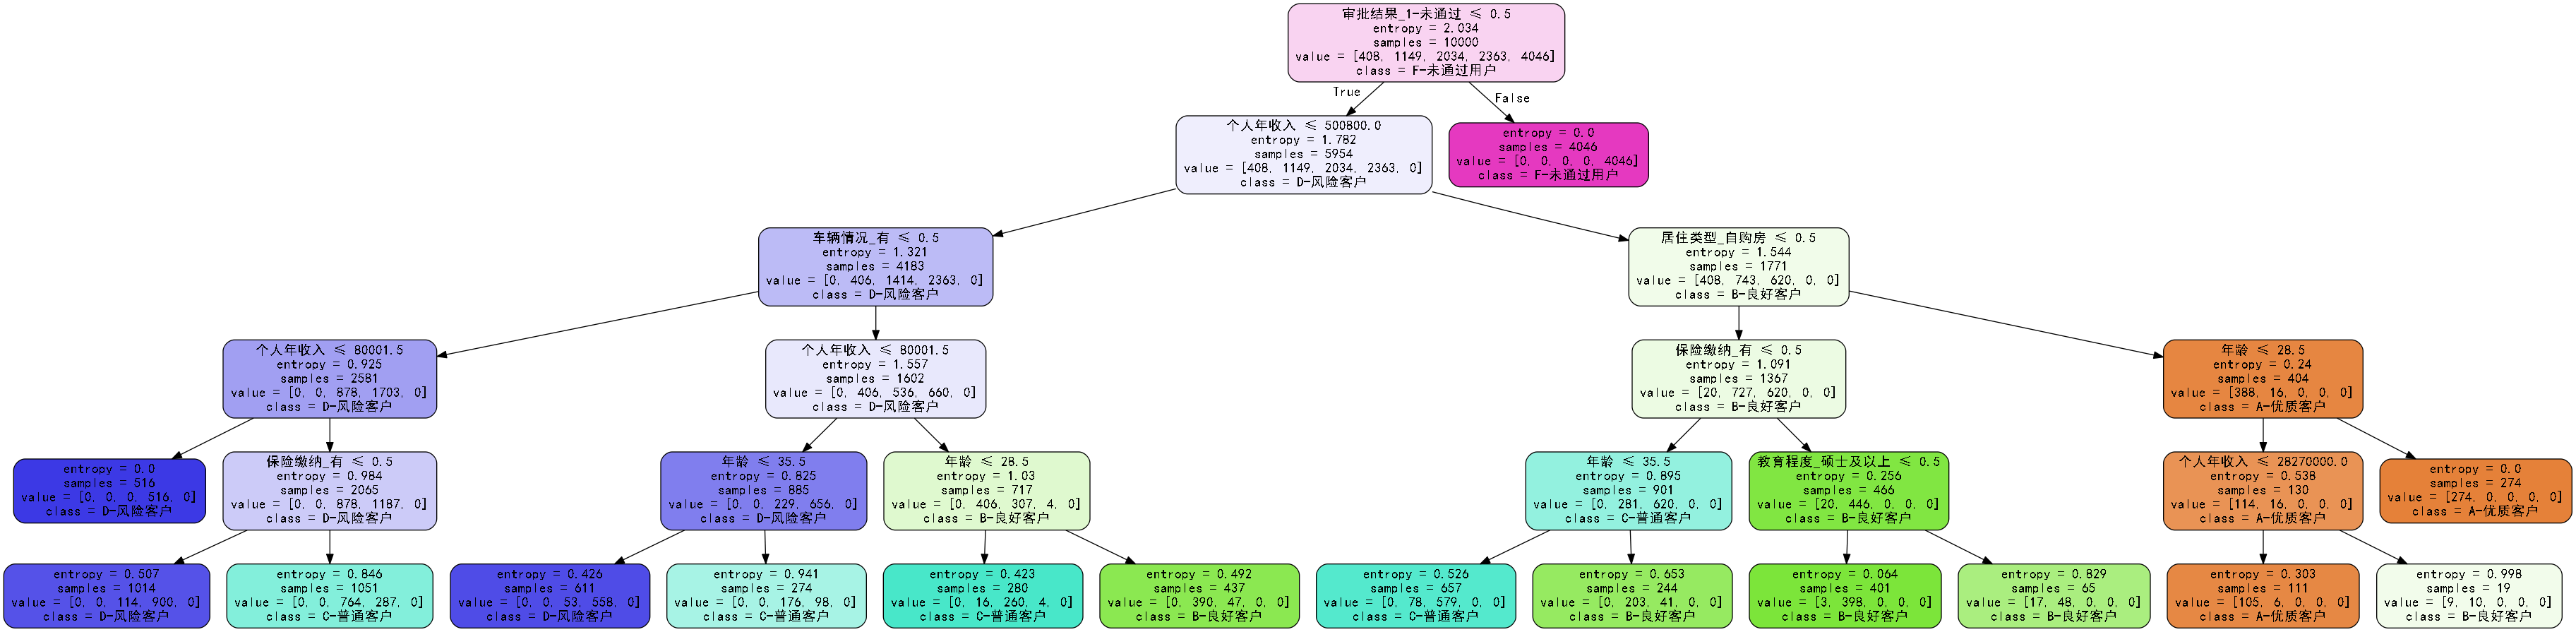

In [3]:
clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=5)
clf = clf.fit(X,Y)
Credit_Level=np.unique(Y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=np.unique(Y),filled=True, rounded=True,special_characters=True,fontname='simhei')
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png(), width=1000)

In [4]:
#计算模型准确率
y_preds = clf.predict(X)
print('Accuracy: ',accuracy_score(Y, y_preds))

Accuracy:  0.9227


In [5]:
X.head().T

,0,1,2,3,4
年龄,45.0,21.0,22.0,2.500000e+01,2.500000e+01
工作年限,22.0,1.0,2.0,2.000000e+00,2.000000e+00
个人年收入,10000.0,10000.0,10000.0,5.700000e+09,6.800000e+09
性别_女,1.0,0.0,1.0,0.000000e+00,0.000000e+00
性别_男,0.0,1.0,0.0,1.000000e+00,1.000000e+00
...,...,...,...,...,...
信贷情况_现在没有贷款,0.0,0.0,0.0,1.000000e+00,0.000000e+00
信贷情况_还在拖欠,0.0,0.0,0.0,0.000000e+00,0.000000e+00
信贷情况_逾期还款,0.0,0.0,0.0,0.000000e+00,0.000000e+00
审批结果_0-通过,0.0,0.0,0.0,1.000000e+00,1.000000e+00


##  基础决策树分类效果

In [6]:
def plot_confusion_matrix(cm, labels_name, title):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

决策树结果： 0.9019999999999999
分类效果的混淆矩阵
[[ 115    7    0    0    0]
 [   4  304   36    1    0]
 [   0   92  498   20    0]
 [   0    0  130  579    0]
 [   0    0    0    0 1214]]


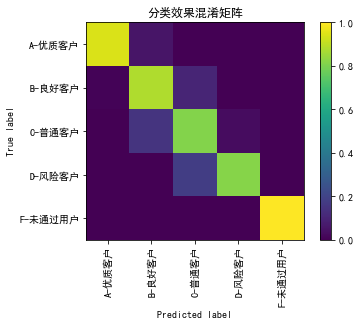

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,stratify=Y)
clf =tree.DecisionTreeClassifier(criterion="gini",max_depth=5)
clf = clf.fit(X_train,y_train)
y_hat=clf.predict(X_test)
y_hat_proba=clf.predict_proba(X_test)

from sklearn.tree import DecisionTreeClassifier
seed = 42
kfold = KFold(n_splits=10,shuffle=True,random_state=seed)
dtree = DecisionTreeClassifier(criterion="gini",max_depth=5)
dtree = dtree.fit(X_train,y_train)
result = cross_val_score(dtree,X_test,y_test,cv=kfold)
print("决策树结果：",result.mean())

y_hat=dtree.predict(X_test)
y_hat_proba=dtree.predict_proba(X)



cm = confusion_matrix(y_test, y_hat)
print('分类效果的混淆矩阵\r')
print(cm)
plot_confusion_matrix(cm,Credit_Level, "分类效果混淆矩阵")
plt.show()


*也可以直接调用seaborn的方法出混淆矩阵图*

Text(35.0, 0.5, 'True label')

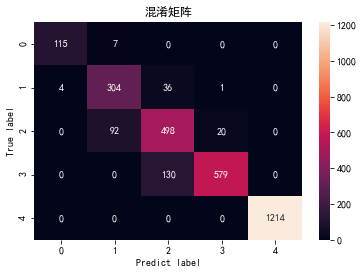

In [8]:
f,ax=plt.subplots()
sns.heatmap(cm,annot=True,ax=ax,fmt='d') #画热力图
ax.set_title('混淆矩阵') #标题
ax.set_xlabel('Predict label') #x轴
ax.set_ylabel('True label') #y轴

##  随机森林分类效果

RandomForestClassifier 随机森林分类结果： 0.9851428571428572


Text(35.0, 0.5, 'True label')

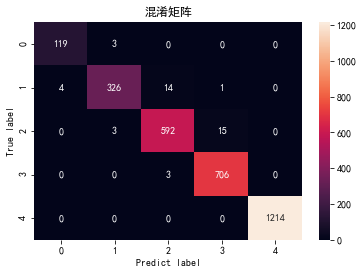

In [9]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20,max_depth=None,min_samples_split=2,random_state=0)
rfc = rfc.fit(X_train,y_train)
scores = cross_val_score(rfc,X_train,y_train,cv=kfold)
print("RandomForestClassifier 随机森林分类结果：",scores.mean())

y_hat=rfc.predict(X_test)
y_hat_proba=rfc.predict_proba(X)

cm = confusion_matrix(y_test, y_hat)
f,ax=plt.subplots()
sns.heatmap(cm,annot=True,ax=ax,fmt='d') #画热力图
ax.set_title('混淆矩阵') #标题
ax.set_xlabel('Predict label') #x轴
ax.set_ylabel('True label') #y轴

## 装袋法BaggingClassifier 分类效果

装袋法提升后结果： 0.9095714285714285


Text(35.0, 0.5, 'True label')

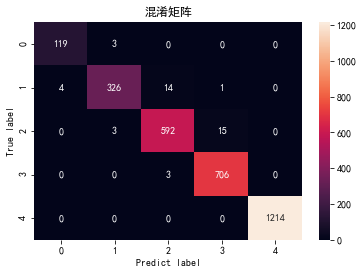

In [10]:
from sklearn.ensemble import BaggingClassifier
bcmodel =BaggingClassifier(base_estimator=dtree,n_estimators=20,random_state=seed)
bcmodel = bcmodel.fit(X_train,y_train)
result = cross_val_score(bcmodel,X_train,y_train,cv=kfold)
print("装袋法提升后结果：",result.mean())

y_hat=bcmodel.predict(X_test)
y_hat_proba=bcmodel.predict_proba(X)


f,ax=plt.subplots()
sns.heatmap(cm,annot=True,ax=ax,fmt='d') #画热力图
ax.set_title('混淆矩阵') #标题
ax.set_xlabel('Predict label') #x轴
ax.set_ylabel('True label') #y轴

## 提升法AdaBoostClassifier分类效果

提升法改进结果： 0.9797142857142859


Text(35.0, 0.5, 'True label')

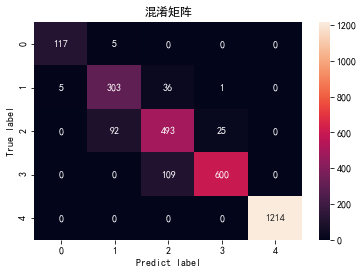

In [11]:
from sklearn.ensemble import AdaBoostClassifier
abc_model=AdaBoostClassifier(base_estimator=dtree,n_estimators=20,random_state=seed)
abc_model=abc_model.fit(X_train,y_train)
result = cross_val_score(abc_model,X_train,y_train,cv=kfold)
print("提升法改进结果：",result.mean())

cm = confusion_matrix(y_test, y_hat)
f,ax=plt.subplots()
sns.heatmap(cm,annot=True,ax=ax,fmt='d') #画热力图
ax.set_title('混淆矩阵') #标题
ax.set_xlabel('Predict label') #x轴
ax.set_ylabel('True label') #y轴